In [1]:
#!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


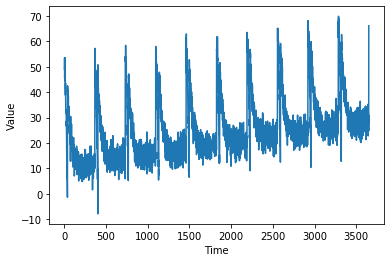

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=-1), input_shape=[None]),
    # YOUR CODE HERE
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x*10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 1s 8ms/step - loss: 20.3828 - mae: 20.8828 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 1s 7ms/step - loss: 20.3543 - mae: 20.8543 - lr: 1.1220e-08
Epoch 3/100
94/94 [==============================] - 1s 8ms/step - loss: 20.3218 - mae: 20.8218 - lr: 1.2589e-08
Epoch 4/100
94/94 [==============================] - 1s 7ms/step - loss: 20.2852 - mae: 20.7851 - lr: 1.4125e-08
Epoch 5/100
94/94 [==============================] - 1s 7ms/step - loss: 20.2436 - mae: 20.7436 - lr: 1.5849e-08
Epoch 6/100
94/94 [==============================] - 1s 7ms/step - loss: 20.1964 - mae: 20.6964 - lr: 1.7783e-08
Epoch 7/100
94/94 [==============================] - 1s 7ms/step - loss: 20.1429 - mae: 20.6429 - lr: 1.9953e-08
Epoch 8/100
94/94 [==============================] - 1s 8ms/step - loss: 20.0823 - mae: 20.5823 - lr: 2.2387e-08
Epoch 9/100
94/94 [==============================] - 1s 8ms/step - loss: 20.0140 - mae: 20.5140 

94/94 [==============================] - 1s 7ms/step - loss: 3.8482 - mae: 4.3125 - lr: 3.9811e-05
Epoch 74/100
94/94 [==============================] - 1s 7ms/step - loss: 3.6995 - mae: 4.1624 - lr: 4.4668e-05
Epoch 75/100
94/94 [==============================] - 1s 7ms/step - loss: 3.6424 - mae: 4.1067 - lr: 5.0119e-05
Epoch 76/100
94/94 [==============================] - 1s 7ms/step - loss: 3.5903 - mae: 4.0537 - lr: 5.6234e-05
Epoch 77/100
94/94 [==============================] - 1s 7ms/step - loss: 3.4728 - mae: 3.9417 - lr: 6.3096e-05
Epoch 78/100
94/94 [==============================] - 1s 7ms/step - loss: 3.4173 - mae: 3.8815 - lr: 7.0795e-05
Epoch 79/100
94/94 [==============================] - 1s 7ms/step - loss: 3.2418 - mae: 3.7067 - lr: 7.9433e-05
Epoch 80/100
94/94 [==============================] - 1s 7ms/step - loss: 3.3344 - mae: 3.7988 - lr: 8.9125e-05
Epoch 81/100
94/94 [==============================] - 1s 7ms/step - loss: 3.0789 - mae: 3.5433 - lr: 1.0000e-04
Epoch

[1e-08, 0.0001, 0, 30]

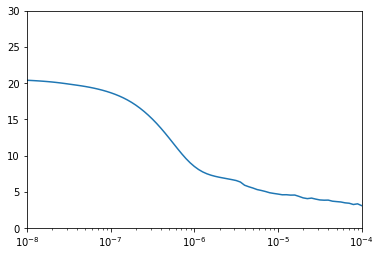

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=-1)),
    # YOUR CODE HERE
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Lambda(lambda x:x*100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/500
94/94 [==============================] - 1s 7ms/step - loss: 176.6868 - mae: 9.2008
Epoch 2/500
94/94 [==============================] - 1s 7ms/step - loss: 95.4130 - mae: 6.6883
Epoch 3/500
94/94 [==============================] - 1s 7ms/step - loss: 83.3996 - mae: 6.0688
Epoch 4/500
94/94 [==============================] - 1s 7ms/step - loss: 78.1761 - mae: 5.8098
Epoch 5/500
94/94 [==============================] - 1s 7ms/step - loss: 72.6976 - mae: 5.5232
Epoch 6/500
94/94 [==============================] - 1s 7ms/step - loss: 70.5972 - mae: 5.3715
Epoch 7/500
94/94 [==============================] - 1s 7ms/step - loss: 65.7968 - mae: 5.0991
Epoch 8/500
94/94 [==============================] - 1s 8ms/step - loss: 63.8812 - mae: 5.0745
Epoch 9/500
94/94 [==============================] - 1s 8ms/step - loss: 63.1525 - mae: 5.1113
Epoch 10/500
94/94 [==============================] - 1s 8ms/step - loss: 58.1606 - mae: 4.8289
Epoch 11/500
94/94 [============================

94/94 [==============================] - 1s 7ms/step - loss: 28.4217 - mae: 3.5561
Epoch 87/500
94/94 [==============================] - 1s 7ms/step - loss: 27.5143 - mae: 3.4947
Epoch 88/500
94/94 [==============================] - 1s 7ms/step - loss: 26.5346 - mae: 3.3709
Epoch 89/500
94/94 [==============================] - 1s 7ms/step - loss: 27.8778 - mae: 3.5348
Epoch 90/500
94/94 [==============================] - 1s 7ms/step - loss: 27.3156 - mae: 3.4356
Epoch 91/500
94/94 [==============================] - 1s 7ms/step - loss: 26.8619 - mae: 3.4312
Epoch 92/500
94/94 [==============================] - 1s 7ms/step - loss: 29.6723 - mae: 3.7040
Epoch 93/500
94/94 [==============================] - 1s 7ms/step - loss: 28.6343 - mae: 3.6068
Epoch 94/500
94/94 [==============================] - 1s 7ms/step - loss: 27.0659 - mae: 3.4798
Epoch 95/500
94/94 [==============================] - 1s 8ms/step - loss: 28.1272 - mae: 3.5341
Epoch 96/500
94/94 [==============================] -

94/94 [==============================] - 1s 7ms/step - loss: 24.9926 - mae: 3.3540
Epoch 171/500
94/94 [==============================] - 1s 7ms/step - loss: 25.7174 - mae: 3.4241
Epoch 172/500
94/94 [==============================] - 1s 7ms/step - loss: 24.7046 - mae: 3.3204
Epoch 173/500
94/94 [==============================] - 1s 7ms/step - loss: 25.0308 - mae: 3.3620
Epoch 174/500
94/94 [==============================] - 1s 7ms/step - loss: 25.0349 - mae: 3.3906
Epoch 175/500
94/94 [==============================] - 1s 7ms/step - loss: 24.7245 - mae: 3.3254
Epoch 176/500
94/94 [==============================] - 1s 7ms/step - loss: 25.2188 - mae: 3.3725
Epoch 177/500
94/94 [==============================] - 1s 7ms/step - loss: 25.2014 - mae: 3.3724
Epoch 178/500
94/94 [==============================] - 1s 7ms/step - loss: 26.1008 - mae: 3.4643
Epoch 179/500
94/94 [==============================] - 1s 7ms/step - loss: 24.2125 - mae: 3.2759
Epoch 180/500
94/94 [=======================

94/94 [==============================] - 1s 7ms/step - loss: 23.7227 - mae: 3.2788
Epoch 255/500
94/94 [==============================] - 1s 7ms/step - loss: 24.6483 - mae: 3.3686
Epoch 256/500
94/94 [==============================] - 1s 7ms/step - loss: 24.3913 - mae: 3.3509
Epoch 257/500
94/94 [==============================] - 1s 7ms/step - loss: 24.0244 - mae: 3.3077
Epoch 258/500
94/94 [==============================] - 1s 7ms/step - loss: 23.7885 - mae: 3.2720
Epoch 259/500
94/94 [==============================] - 1s 7ms/step - loss: 24.5282 - mae: 3.3790
Epoch 260/500
94/94 [==============================] - 1s 7ms/step - loss: 24.7519 - mae: 3.3927
Epoch 261/500
94/94 [==============================] - 1s 7ms/step - loss: 23.7293 - mae: 3.2873
Epoch 262/500
94/94 [==============================] - 1s 7ms/step - loss: 23.6339 - mae: 3.2598
Epoch 263/500
94/94 [==============================] - 1s 7ms/step - loss: 22.9816 - mae: 3.2098
Epoch 264/500
94/94 [=======================

94/94 [==============================] - 1s 7ms/step - loss: 22.2078 - mae: 3.1467
Epoch 339/500
94/94 [==============================] - 1s 7ms/step - loss: 22.6438 - mae: 3.1938
Epoch 340/500
94/94 [==============================] - 1s 7ms/step - loss: 22.5718 - mae: 3.1720
Epoch 341/500
94/94 [==============================] - 1s 7ms/step - loss: 22.3797 - mae: 3.1612
Epoch 342/500
94/94 [==============================] - 1s 7ms/step - loss: 22.1991 - mae: 3.1636
Epoch 343/500
94/94 [==============================] - 1s 7ms/step - loss: 23.0904 - mae: 3.2535
Epoch 344/500
94/94 [==============================] - 1s 7ms/step - loss: 22.5184 - mae: 3.1885
Epoch 345/500
94/94 [==============================] - 1s 7ms/step - loss: 22.9080 - mae: 3.2053
Epoch 346/500
94/94 [==============================] - 1s 7ms/step - loss: 22.6782 - mae: 3.2047
Epoch 347/500
94/94 [==============================] - 1s 7ms/step - loss: 22.6510 - mae: 3.2054
Epoch 348/500
94/94 [=======================

94/94 [==============================] - 1s 7ms/step - loss: 21.7505 - mae: 3.1248
Epoch 423/500
94/94 [==============================] - 1s 7ms/step - loss: 21.7376 - mae: 3.1163
Epoch 424/500
94/94 [==============================] - 1s 7ms/step - loss: 21.9882 - mae: 3.1645
Epoch 425/500
94/94 [==============================] - 1s 7ms/step - loss: 22.1327 - mae: 3.1634
Epoch 426/500
94/94 [==============================] - 1s 7ms/step - loss: 21.9560 - mae: 3.1365
Epoch 427/500
94/94 [==============================] - 1s 7ms/step - loss: 22.0948 - mae: 3.1653
Epoch 428/500
94/94 [==============================] - 1s 7ms/step - loss: 23.8172 - mae: 3.3310
Epoch 429/500
94/94 [==============================] - 1s 7ms/step - loss: 21.9585 - mae: 3.1387
Epoch 430/500
94/94 [==============================] - 1s 7ms/step - loss: 22.1673 - mae: 3.1528
Epoch 431/500
94/94 [==============================] - 1s 7ms/step - loss: 22.1878 - mae: 3.1770
Epoch 432/500
94/94 [=======================

In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()